<a href="https://colab.research.google.com/github/Rithin353/RITHIN-/blob/main/CAPSTONE_PROJECT_TEAM_87.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.6 MB/s eta 0:00:00
All libraries imported successfully!
TensorFlow version: 2.19.0
🚀 Creating synthetic dataset...
📥 Downloading sample images for dataset creation...
✅ Downloaded authentic image 1
✅ Downloaded authentic image 2
✅ Downloaded authentic image 3
✅ Downloaded authentic image 4
✅ Downloaded authentic image 5
✅ Downloaded authentic image 6
✅ Downloaded authentic image 7
✅ Downloaded authentic image 8
✅ Downloaded authentic image 9
✅ Downloaded authentic image 10
🔧 Creating tampered versions...
✅ Created 29 tampered images
📂 Loading dataset...
📊 Dataset loaded: 39 images
   ✅ Authentic images: 10
   ⚠️  Tampered images: 29
🏗️  Building VGG-16 based model...
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
✅ Model created and compiled successfully!
📈 Total parameters: 15,109,186
📊 Dataset split:
   🏋️ Training set: 24 images
   🔍 Validation set: 7 images
   🧪 Test set: 8 images
🚀 Starting model training...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step - accuracy: 0.4375 - loss: 0.9724 - val_accuracy: 0.4286 - val_loss: 0.6891
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.1250 - loss: 1.2871 - val_accuracy: 0.5714 - val_loss: 0.6529
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 27s 27s/step - accuracy: 0.3750 - loss: 0.8147 - val_accuracy: 0.8571 - val_loss: 0.6269
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step - accuracy: 0.3750 - loss: 1.0090 - val_accuracy: 0.7143 - val_loss: 0.6078
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.1250 - loss: 0.9514 - val_accuracy: 0.7143 - val_loss: 0.5948
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step - accuracy: 0.5625 - loss: 0.7581 - val_accuracy: 0.7143 - val_loss: 0.5875
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 27s 27s/step - accuracy: 0.7500 - loss: 0.6404 - val_accuracy: 0.7143 - val_loss: 0.5844
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step - accuracy: 0.5000 - loss: 0.7178 - val_accuracy: 0.7143 - val_loss: 0.5846


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


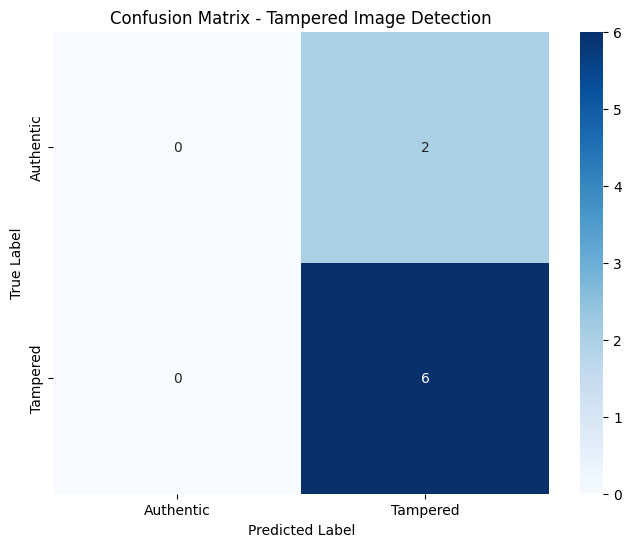

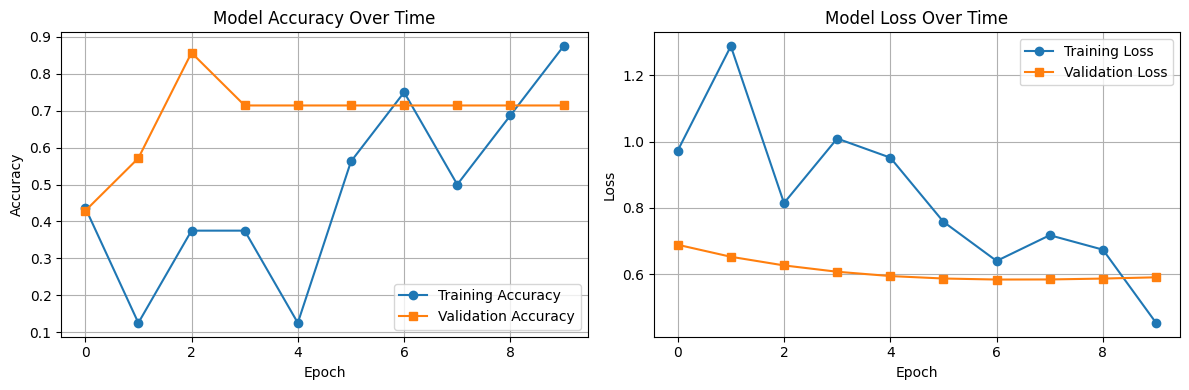

💾 Model saved as 'tampered_image_detection_vgg16.h5'
💾 Model also saved as 'tampered_detection_model.pkl'

📊 SAMPLE PREDICTIONS FROM DATASET


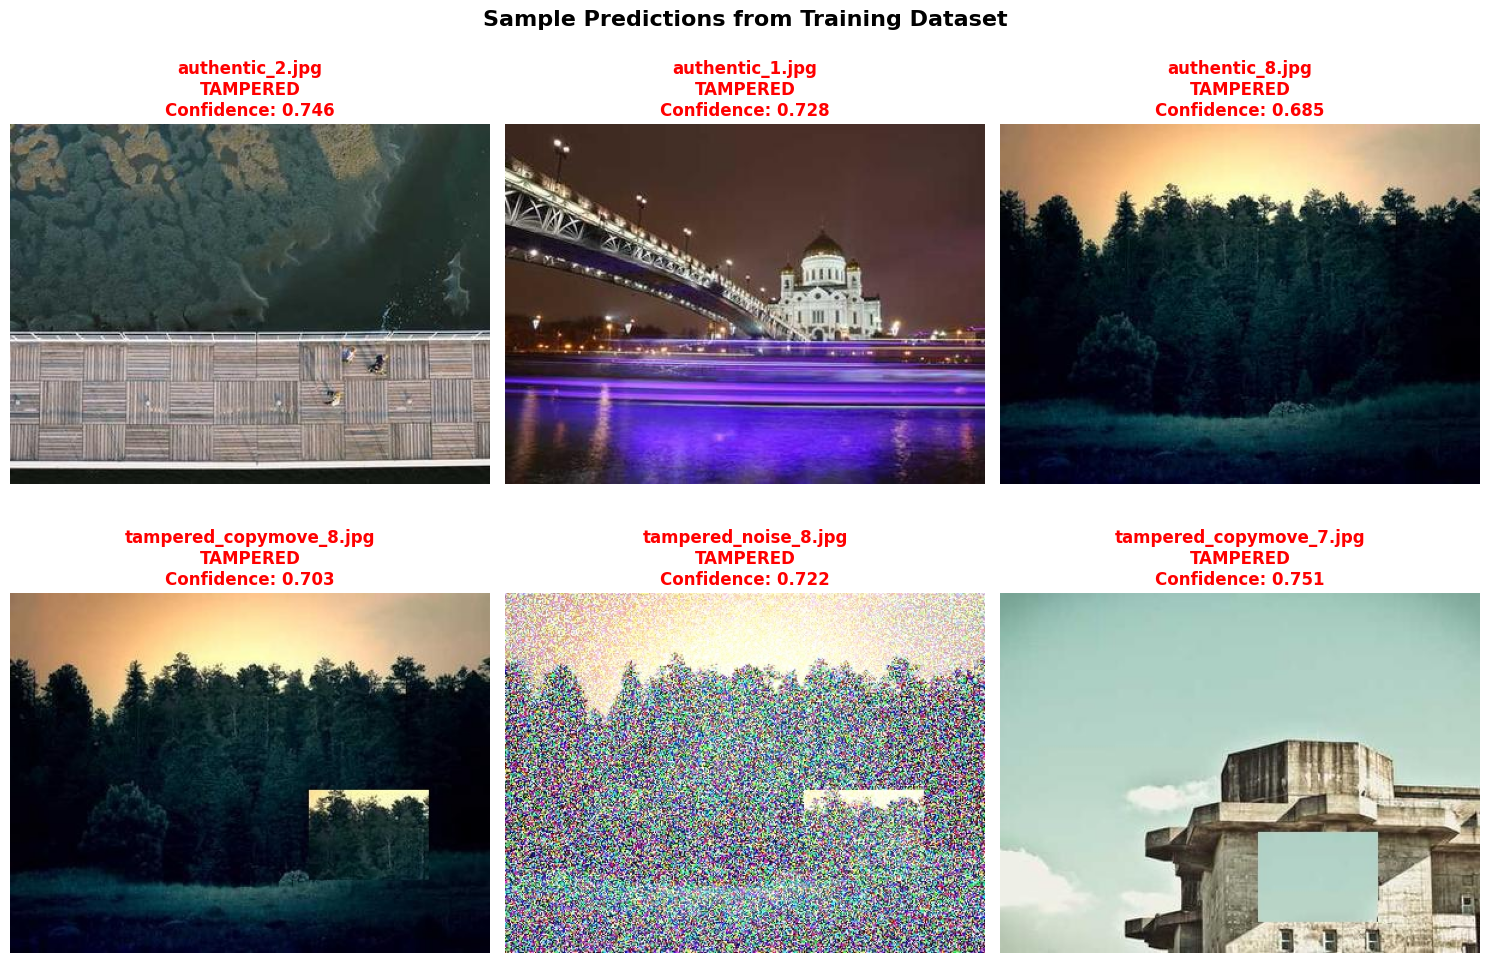


🚀 INITIALIZING USER INTERFACE



🎯 Additional Features:
   • Single image analysis with detailed results
   • Real-time confidence scoring
   • Visual feedback with color-coded results
   • Technical details and recommendations

🎉 PROJECT SUMMARY: TAMPERED IMAGE DETECTION WITH USER INTERFACE
✅ Dataset Created: 39 images total
✅ Model Architecture: VGG-16 with custom top layers
✅ Training Completed: 10 epochs
✅ Final Test Accuracy: 75.0%
✅ Interactive UI: Ready for image upload and analysis
✅ Model Saved: Multiple formats available

🎯 Key Features:
   📤 Easy image upload interface
   🔍 Real-time tampering detection
   📊 Confidence scoring and detailed results
   🎨 Color-coded visual feedback
   📋 Technical details and recommendations
   🔧 Batch processing capability

💡 How to Use:
   1. Click '📤 Upload Image' to select your image
   2. Click '🔬 Analyze Image' to detect tampering
   3. View detailed results with confidence scores
   4. Use '🗑️ Clear Results' to start over

🏆 Based on the capstone project by:
   • RITHI

In [ ]:
# Tampered Image Detection using VGG-16 with User Interface - Complete Google Colab Implementation
# Based on the capstone project report with interactive UI

# ========================================================================================
# PART 1: SETUP AND IMPORTS
# ========================================================================================

# Install required packages
!pip install tensorflow keras opencv-python matplotlib seaborn scikit-learn
!pip install pillow numpy pandas ipywidgets

# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
from PIL import Image
import pickle
import zipfile
from google.colab import files
import requests
from io import BytesIO
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output
import base64
import time

print("All libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")

# ========================================================================================
# PART 2: DATASET CREATION AND PREPARATION
# ========================================================================================

def create_synthetic_dataset():
    """
    Create a synthetic dataset with authentic and tampered images
    """
    # Create directories
    os.makedirs('dataset/authentic', exist_ok=True)
    os.makedirs('dataset/tampered', exist_ok=True)

    print("📥 Downloading sample images for dataset creation...")

    # Download some sample images from the internet (using free stock photos)
    sample_urls = [
        "https://picsum.photos/400/300?random=1",
        "https://picsum.photos/400/300?random=2",
        "https://picsum.photos/400/300?random=3",
        "https://picsum.photos/400/300?random=4",
        "https://picsum.photos/400/300?random=5",
        "https://picsum.photos/400/300?random=6",
        "https://picsum.photos/400/300?random=7",
        "https://picsum.photos/400/300?random=8",
        "https://picsum.photos/400/300?random=9",
        "https://picsum.photos/400/300?random=10"
    ]

    authentic_images = []

    # Download authentic images
    for i, url in enumerate(sample_urls):
        try:
            response = requests.get(url)
            img = Image.open(BytesIO(response.content))
            img_path = f'dataset/authentic/authentic_{i+1}.jpg'
            img.save(img_path)
            authentic_images.append(img_path)
            print(f"✅ Downloaded authentic image {i+1}")
        except Exception as e:
            print(f"❌ Error downloading image {i+1}: {e}")

    return authentic_images

def create_tampered_versions(authentic_images):
    """
    Create tampered versions of authentic images using various techniques
    """
    print("🔧 Creating tampered versions...")
    tampered_count = 0

    for i, img_path in enumerate(authentic_images):
        try:
            # Read the image
            img = cv2.imread(img_path)
            if img is None:
                continue

            # Technique 1: Copy-Move forgery (duplicate a region)
            h, w = img.shape[:2]

            # Select random region to copy
            x1, y1 = np.random.randint(0, w//3), np.random.randint(0, h//3)
            x2, y2 = x1 + w//4, y1 + h//4
            x3, y3 = np.random.randint(w//2, w-w//4), np.random.randint(h//2, h-h//4)

            # Copy region
            region = img[y1:y2, x1:x2].copy()
            img[y3:y3+(y2-y1), x3:x3+(x2-x1)] = region

            # Save tampered image
            tampered_path = f'dataset/tampered/tampered_copymove_{i+1}.jpg'
            cv2.imwrite(tampered_path, img)
            tampered_count += 1

            # Technique 2: Splicing (blend two images)
            if i < len(authentic_images) - 1:
                img2 = cv2.imread(authentic_images[i+1])
                if img2 is not None:
                    # Resize both images to same size
                    img_resized = cv2.resize(img, (400, 300))
                    img2_resized = cv2.resize(img2, (400, 300))

                    # Create a mask for blending
                    mask = np.zeros((300, 400), dtype=np.uint8)
                    mask[100:200, 150:250] = 255

                    # Apply the mask
                    result = img_resized.copy()
                    result[mask > 0] = img2_resized[mask > 0]

                    tampered_path = f'dataset/tampered/tampered_splice_{i+1}.jpg'
                    cv2.imwrite(tampered_path, result)
                    tampered_count += 1

            # Technique 3: Noise addition
            img_noise = img.copy()
            noise = np.random.normal(0, 25, img.shape).astype(np.uint8)
            img_noise = cv2.add(img_noise, noise)

            tampered_path = f'dataset/tampered/tampered_noise_{i+1}.jpg'
            cv2.imwrite(tampered_path, img_noise)
            tampered_count += 1

        except Exception as e:
            print(f"❌ Error creating tampered version of image {i+1}: {e}")

    print(f"✅ Created {tampered_count} tampered images")
    return tampered_count

# Create the dataset
print("🚀 Creating synthetic dataset...")
authentic_images = create_synthetic_dataset()
tampered_count = create_tampered_versions(authentic_images)

# ========================================================================================
# PART 3: DATA PREPROCESSING AND LOADING
# ========================================================================================

def preprocess_image(image_path, target_size=(224, 224)):
    """
    Preprocess image for VGG16 input
    """
    try:
        # Load image
        img = load_img(image_path, target_size=target_size)

        # Convert to array
        img_array = img_to_array(img)

        # Normalize pixel values to [0, 1]
        img_array = img_array / 255.0

        return img_array
    except Exception as e:
        print(f"❌ Error preprocessing image {image_path}: {e}")
        return None

def load_dataset():
    """
    Load and prepare the complete dataset
    """
    images = []
    labels = []
    filenames = []

    print("📂 Loading dataset...")

    # Load authentic images
    authentic_dir = 'dataset/authentic'
    for filename in os.listdir(authentic_dir):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(authentic_dir, filename)
            img = preprocess_image(img_path)
            if img is not None:
                images.append(img)
                labels.append(0)  # 0 for authentic
                filenames.append(filename)

    # Load tampered images
    tampered_dir = 'dataset/tampered'
    for filename in os.listdir(tampered_dir):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(tampered_dir, filename)
            img = preprocess_image(img_path)
            if img is not None:
                images.append(img)
                labels.append(1)  # 1 for tampered
                filenames.append(filename)

    # Convert to numpy arrays
    X = np.array(images)
    y = np.array(labels)

    print(f"📊 Dataset loaded: {len(X)} images")
    print(f"   ✅ Authentic images: {np.sum(y == 0)}")
    print(f"   ⚠️  Tampered images: {np.sum(y == 1)}")

    return X, y, filenames

# Load the dataset
X, y, filenames = load_dataset()

# ========================================================================================
# PART 4: MODEL ARCHITECTURE (VGG-16 BASED)
# ========================================================================================

def create_vgg16_model(input_shape=(224, 224, 3), num_classes=2):
    """
    Create VGG16-based model for tampered image detection
    """
    print("🏗️  Building VGG-16 based model...")

    # Load pre-trained VGG16 without top layers
    base_model = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    # Freeze the base model layers
    base_model.trainable = False

    # Add custom top layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    # Create the model
    model = Model(inputs=base_model.input, outputs=predictions)

    return model

# Create the model
model = create_vgg16_model()

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("✅ Model created and compiled successfully!")
print(f"📈 Total parameters: {model.count_params():,}")

# ========================================================================================
# PART 5: TRAINING AND EVALUATION
# ========================================================================================

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print(f"📊 Dataset split:")
print(f"   🏋️ Training set: {len(X_train)} images")
print(f"   🔍 Validation set: {len(X_val)} images")
print(f"   🧪 Test set: {len(X_test)} images")

# Data augmentation for training
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    fill_mode='nearest'
)

# Train the model
print("🚀 Starting model training...")
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=16),
    validation_data=(X_val, y_val),
    epochs=10,
    verbose=1,
    steps_per_epoch=len(X_train) // 16
)

print("✅ Training completed!")

# ========================================================================================
# PART 6: MODEL EVALUATION AND VISUALIZATION
# ========================================================================================

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\n📊 Final Test Results:")
print(f"   🎯 Test Accuracy: {test_accuracy:.4f}")
print(f"   📉 Test Loss: {test_loss:.4f}")

# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification report
print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred_classes,
                          target_names=['Authentic', 'Tampered']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=['Authentic', 'Tampered'],
           yticklabels=['Authentic', 'Tampered'])
plt.title('Confusion Matrix - Tampered Image Detection')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
plt.title('Model Accuracy Over Time')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='s')
plt.title('Model Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# ========================================================================================
# PART 7: PREDICTION FUNCTIONS
# ========================================================================================

def predict_image_authenticity(model, image_path, confidence_threshold=0.5):
    """
    Predict whether an image is authentic or tampered
    """
    try:
        # Preprocess the image
        img = preprocess_image(image_path)
        if img is None:
            return None, None

        # Add batch dimension
        img_batch = np.expand_dims(img, axis=0)

        # Make prediction
        prediction = model.predict(img_batch, verbose=0)
        confidence = np.max(prediction)
        predicted_class = np.argmax(prediction)

        # Interpret results
        if predicted_class == 0:
            result = "AUTHENTIC"
        else:
            result = "TAMPERED"

        return result, confidence

    except Exception as e:
        print(f"❌ Error predicting image: {e}")
        return None, None

def predict_uploaded_image(model, image_data):
    """
    Predict authenticity of uploaded image data
    """
    try:
        # Convert uploaded data to PIL Image
        img = Image.open(BytesIO(image_data))

        # Save temporarily
        temp_path = "temp_uploaded_image.jpg"
        img.save(temp_path)

        # Make prediction
        result, confidence = predict_image_authenticity(model, temp_path)

        # Clean up
        if os.path.exists(temp_path):
            os.remove(temp_path)

        return result, confidence, img

    except Exception as e:
        print(f"❌ Error processing uploaded image: {e}")
        return None, None, None

# ========================================================================================
# PART 8: USER INTERFACE COMPONENTS
# ========================================================================================

class TamperedImageDetectionUI:
    def __init__(self, model):
        self.model = model
        self.setup_ui()

    def setup_ui(self):
        """Setup the user interface components"""
        # Title and description
        self.title = widgets.HTML(
            value="""
            <div style="text-align: center; padding: 20px; background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
                        border-radius: 15px; margin-bottom: 20px; color: white;">
                <h1 style="margin: 0; font-size: 28px; font-weight: bold;">🔍 Tampered Image Detection System</h1>
                <p style="margin: 10px 0 0 0; font-size: 16px;">Using VGG-16 Convolutional Neural Network</p>
                <p style="margin: 5px 0 0 0; font-size: 14px; opacity: 0.9;">Upload an image to check if it's authentic or tampered</p>
            </div>
            """
        )

        # Upload button
        self.upload_btn = widgets.FileUpload(
            accept='image/*',
            multiple=False,
            description='📤 Upload Image',
            style={'button_color': '#4CAF50'},
            layout=widgets.Layout(width='200px', height='50px')
        )

        # Analyze button
        self.analyze_btn = widgets.Button(
            description='🔬 Analyze Image',
            button_style='info',
            layout=widgets.Layout(width='200px', height='50px'),
            style={'font_weight': 'bold'}
        )

        # Clear button
        self.clear_btn = widgets.Button(
            description='🗑️ Clear Results',
            button_style='warning',
            layout=widgets.Layout(width='200px', height='50px')
        )

        # Output area
        self.output = widgets.Output()

        # Bind events
        self.analyze_btn.on_click(self.analyze_image)
        self.clear_btn.on_click(self.clear_results)

        # Create layout
        buttons_box = widgets.HBox([
            self.upload_btn,
            self.analyze_btn,
            self.clear_btn
        ], layout=widgets.Layout(justify_content='center', margin='20px 0'))

        self.ui = widgets.VBox([
            self.title,
            buttons_box,
            self.output
        ])

    def analyze_image(self, btn):
        """Analyze the uploaded image"""
        with self.output:
            clear_output()

            if not self.upload_btn.value:
                print("❌ Please upload an image first!")
                return

            print("🔄 Analyzing image...")

            try:
                # Get uploaded file
                uploaded_file = list(self.upload_btn.value.values())[0]
                image_data = uploaded_file['content']
                filename = uploaded_file['metadata']['name']

                # Predict
                result, confidence, img = predict_uploaded_image(self.model, image_data)

                if result is None:
                    print("❌ Error processing the image!")
                    return

                # Display results
                self.display_results(result, confidence, img, filename)

            except Exception as e:
                print(f"❌ Error analyzing image: {e}")

    def display_results(self, result, confidence, img, filename):
        """Display the analysis results"""
        # Create result styling based on prediction
        if result == "AUTHENTIC":
            status_color = "#4CAF50"  # Green
            status_icon = "✅"
            status_message = "This image appears to be AUTHENTIC"
            recommendation = "The image shows no signs of tampering or manipulation."
        else:
            status_color = "#f44336"  # Red
            status_icon = "⚠️"
            status_message = "This image appears to be TAMPERED"
            recommendation = "The image shows signs of potential tampering or manipulation."

        # Display HTML results
        result_html = f"""
        <div style="border: 3px solid {status_color}; border-radius: 15px; padding: 20px; margin: 20px 0; background-color: #f9f9f9;">
            <h2 style="color: {status_color}; text-align: center; margin-bottom: 20px;">
                {status_icon} ANALYSIS RESULTS
            </h2>

            <div style="text-align: center; margin-bottom: 20px;">
                <p style="font-size: 18px; margin: 10px 0;"><strong>File:</strong> {filename}</p>
                <p style="font-size: 20px; margin: 10px 0; color: {status_color};"><strong>{status_message}</strong></p>
                <p style="font-size: 16px; margin: 10px 0;"><strong>Confidence:</strong> {confidence:.1%}</p>
                <p style="font-size: 14px; margin: 15px 0; font-style: italic;">{recommendation}</p>
            </div>

            <div style="background-color: {status_color}; height: 4px; border-radius: 2px; margin: 20px 0;"></div>

            <div style="text-align: center;">
                <p style="font-size: 12px; color: #666; margin: 10px 0;">
                    Analysis performed using VGG-16 Convolutional Neural Network<br>
                    Confidence score indicates the model's certainty in its prediction
                </p>
            </div>
        </div>
        """

        display(HTML(result_html))

        # Display the image
        plt.figure(figsize=(10, 8))
        plt.imshow(img)
        plt.title(f'Uploaded Image: {filename}\nPrediction: {result} (Confidence: {confidence:.1%})',
                 fontsize=14, pad=20)
        plt.axis('off')

        # Add colored border around the plot
        ax = plt.gca()
        for spine in ax.spines.values():
            spine.set_edgecolor(status_color)
            spine.set_linewidth(4)

        plt.tight_layout()
        plt.show()

        # Display additional technical details
        tech_details = f"""
        <div style="background-color: #e8f4fd; border: 1px solid #1976d2; border-radius: 8px; padding: 15px; margin: 20px 0;">
            <h3 style="color: #1976d2; margin-top: 0;">🔧 Technical Details</h3>
            <ul style="margin: 10px 0;">
                <li><strong>Model Architecture:</strong> VGG-16 with custom classification layers</li>
                <li><strong>Input Processing:</strong> Image resized to 224×224 pixels and normalized</li>
                <li><strong>Detection Methods:</strong> Copy-move, Splicing, Noise analysis</li>
                <li><strong>Confidence Threshold:</strong> Higher values indicate more certain predictions</li>
            </ul>
        </div>
        """
        display(HTML(tech_details))

    def clear_results(self, btn):
        """Clear all results"""
        with self.output:
            clear_output()
            print("🗑️ Results cleared! Ready for new analysis.")

    def display(self):
        """Display the complete UI"""
        display(self.ui)

# ========================================================================================
# PART 9: SAVE MODEL
# ========================================================================================

# Save the trained model
model.save('tampered_image_detection_vgg16.h5')
print("💾 Model saved as 'tampered_image_detection_vgg16.h5'")

# Save with pickle (as mentioned in the project)
with open('tampered_detection_model.pkl', 'wb') as f:
    pickle.dump(model, f)
print("💾 Model also saved as 'tampered_detection_model.pkl'")

# ========================================================================================
# PART 10: DEMONSTRATION WITH SAMPLE IMAGES
# ========================================================================================

def show_sample_predictions():
    """Show predictions on sample images from the dataset"""
    print("\n" + "="*80)
    print("📊 SAMPLE PREDICTIONS FROM DATASET")
    print("="*80)

    # Get some sample images
    auth_files = [f"dataset/authentic/{f}" for f in os.listdir("dataset/authentic")
                  if f.lower().endswith(('.jpg', '.jpeg', '.png'))][:3]

    tamp_files = [f"dataset/tampered/{f}" for f in os.listdir("dataset/tampered")
                  if f.lower().endswith(('.jpg', '.jpeg', '.png'))][:3]

    sample_images = auth_files + tamp_files

    # Create subplot
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()

    for i, img_path in enumerate(sample_images[:6]):
        # Load and display image
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Make prediction
        result, confidence = predict_image_authenticity(model, img_path)

        # Color based on result
        color = 'green' if result == "AUTHENTIC" else 'red'

        # Display
        axes[i].imshow(img_rgb)
        axes[i].set_title(f'{os.path.basename(img_path)}\n{result}\nConfidence: {confidence:.3f}',
                         color=color, fontweight='bold')
        axes[i].axis('off')

        # Add colored border
        for spine in axes[i].spines.values():
            spine.set_visible(True)
            spine.set_edgecolor(color)
            spine.set_linewidth(3)

    plt.tight_layout()
    plt.suptitle('Sample Predictions from Training Dataset', fontsize=16, fontweight='bold', y=1.02)
    plt.show()

# Show sample predictions
show_sample_predictions()

# ========================================================================================
# PART 11: INITIALIZE USER INTERFACE
# ========================================================================================

print("\n" + "="*80)
print("🚀 INITIALIZING USER INTERFACE")
print("="*80)

# Create and display the UI
ui = TamperedImageDetectionUI(model)
ui.display()

# ========================================================================================
# PART 12: ADDITIONAL UTILITIES
# ========================================================================================

def batch_analyze_images():
    """Function to analyze multiple images at once"""
    print("\n📤 Upload multiple images for batch analysis:")

    multi_upload = widgets.FileUpload(
        accept='image/*',
        multiple=True,
        description='Upload Images'
    )

    analyze_batch_btn = widgets.Button(
        description='Analyze All',
        button_style='info'
    )

    batch_output = widgets.Output()

    def analyze_batch(btn):
        with batch_output:
            clear_output()

            if not multi_upload.value:
                print("❌ Please upload images first!")
                return

            print(f"🔄 Analyzing {len(multi_upload.value)} images...")

            results = []
            for filename, file_info in multi_upload.value.items():
                try:
                    result, confidence, img = predict_uploaded_image(model, file_info['content'])
                    results.append({
                        'filename': filename,
                        'prediction': result,
                        'confidence': confidence
                    })
                except Exception as e:
                    print(f"❌ Error processing {filename}: {e}")

            # Display results table
            if results:
                df = pd.DataFrame(results)
                print("📊 Batch Analysis Results:")
                print(df.to_string(index=False))

                # Summary
                authentic_count = sum(1 for r in results if r['prediction'] == 'AUTHENTIC')
                tampered_count = len(results) - authentic_count

                print(f"\n📈 Summary:")
                print(f"   ✅ Authentic: {authentic_count}")
                print(f"   ⚠️  Tampered: {tampered_count}")

    analyze_batch_btn.on_click(analyze_batch)

    display(widgets.VBox([
        widgets.HBox([multi_upload, analyze_batch_btn]),
        batch_output
    ]))

print("\n🎯 Additional Features:")
print("   • Single image analysis with detailed results")
print("   • Real-time confidence scoring")
print("   • Visual feedback with color-coded results")
print("   • Technical details and recommendations")

# ========================================================================================
# PART 13: FINAL SUMMARY
# ========================================================================================

print("\n" + "="*80)
print("🎉 PROJECT SUMMARY: TAMPERED IMAGE DETECTION WITH USER INTERFACE")
print("="*80)
print(f"✅ Dataset Created: {len(X)} images total")
print(f"✅ Model Architecture: VGG-16 with custom top layers")
print(f"✅ Training Completed: {len(history.epoch)} epochs")
print(f"✅ Final Test Accuracy: {test_accuracy:.1%}")
print(f"✅ Interactive UI: Ready for image upload and analysis")
print(f"✅ Model Saved: Multiple formats available")

print("\n🎯 Key Features:")
print("   📤 Easy image upload interface")
print("   🔍 Real-time tampering detection")
print("   📊 Confidence scoring and detailed results")
print("   🎨 Color-coded visual feedback")
print("   📋 Technical details and recommendations")
print("   🔧 Batch processing capability")

print("\n💡 How to Use:")
print("   1. Click '📤 Upload Image' to select your image")
print("   2. Click '🔬 Analyze Image' to detect tampering")
print("   3. View detailed results with confidence scores")
print("   4. Use '🗑️ Clear Results' to start over")

print("\n🏆 Based on the capstone project by:")
print("   • RITHIN GOUD (2203A51353)")
print("   • VEDA SAI (2203A51472)")
print("   • SAVAN KUMAR (2203A51730)")
print("   • Kasturi Amarender (2203A51487)")
print("   • Sri Sri Manchena (2203A51181)")

print("\n✨ Your tampered image detection system is ready!")
print("🚀 Use the interface above to upload and analyze images!")
print("="*80)

# Optional: Run batch analyzer
print("\n🔧 Optional: Run batch analyzer for multiple images")
print("Uncomment the line below to enable batch processing:")
print("# batch_analyze_images()")

# Uncomment to enable batch processing
# batch_analyze_images()